<a href="https://colab.research.google.com/github/wirungu/deep-learning-finance/blob/main/Deep_Learning_in_Financial_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

I recently ran across this [implementation](https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233)  of an LSTM network for stock price prediction, which seemed to me to have some mistakes. (Exercise: What's the main thing wrong with the forecasting?)

I was still curious how effective a crude RNN time series model could be, and particularly whether even the naive benchmark could be beaten given that certain strong forms of the EMH would seem to forbid this: shouldn't today's price be in some sense the best possible indicator for tomorrow's price? Do standard deep learning approaches match or exceed cutting-edge *classical* time series techniques on financial data?
This is my attempt at finding out, and an excuse to learn more about deep learning, time series forecasting and finance.

I've tried to indicate it whenever I actively choose between different possible approaches, and to document anything I'm unsure about in hopes that someone wiser will gently steer me towards a better approach.

# Modules and data preprocessing

## Installation

In [1]:
!pip install prophet
!pip install --upgrade yfinance
!pip install autokeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.22
    Uninstalling yfinance-0.2.22:
      Successfully uninstalled yfinance-0.2.22
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.6/148.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 576.5/576.5 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.0/728.0 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 31.2 MB/s eta 0:00:00
  Attempting uninstall: typing-ext

In [2]:
import autokeras as ak
import prophet
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import yfinance as yf

Using TensorFlow backend


Instead of messing with CSVs we'll just use the [Yahoo! Finance API yfinance](https://pypi.org/project/yfinance/) . We'll analyze `MSFT` as a warmup since that's the ticker in the example code there.


In [3]:
msft = yf.Ticker("MSFT")
# get all stock info
msft.info

{'address1': 'One Microsoft Way',
 'city': 'Redmond',
 'state': 'WA',
 'zip': '98052-6399',
 'country': 'United States',
 'phone': '425 882 8080',
 'fax': '425 706 7329',
 'website': 'https://www.microsoft.com',
 'industry': 'Software—Infrastructure',
 'industryDisp': 'Software—Infrastructure',
 'sector': 'Technology',
 'longBusinessSummary': 'Microsoft Corporation develops, licenses, and supports software, services, devices, and solutions worldwide. The company operates in three segments: Productivity and Business Processes, Intelligent Cloud, and More Personal Computing. The Productivity and Business Processes segment offers Office, Exchange, SharePoint, Microsoft Teams, Office 365 Security and Compliance, Microsoft Viva, and Skype for Business; Skype, Outlook.com, OneDrive, and LinkedIn; and Dynamics 365, a set of cloud-based and on-premises business solutions for organizations and enterprise divisions. The Intelligent Cloud segment licenses SQL, Windows Servers, Visual Studio, Syst

Yahoo! Finance allows me to access 60 days worth of data at a 5 minute granularity, 7 days of 1 minute data and daily data going back over 10 years. For now we're analyzing 60 days of data, but I may need to change this or seek more and better data from elsewhere.

In [4]:
df = yf.download("MSFT", period= "60d", interval="5m")
# Let's take a look at the data
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-04-19 09:30:00-04:00,285.989990,286.769989,285.600006,286.644989,286.644989,1006171
2023-04-19 09:35:00-04:00,286.619995,286.980011,285.220001,285.290009,285.290009,503674
2023-04-19 09:40:00-04:00,285.279999,285.579987,285.000000,285.450012,285.450012,440315
2023-04-19 09:45:00-04:00,285.450012,286.209991,285.320007,285.940002,285.940002,344039
2023-04-19 09:50:00-04:00,285.899994,286.040009,284.619995,284.625000,284.625000,485759


In [5]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-07-14 15:35:00-04:00,345.100006,345.109985,344.619995,344.864990,344.864990,240343
2023-07-14 15:40:00-04:00,344.850006,345.000000,344.619995,344.649994,344.649994,209030
2023-07-14 15:45:00-04:00,344.660004,344.910004,344.440002,344.579987,344.579987,332041
2023-07-14 15:50:00-04:00,344.609985,345.375000,344.309998,345.000000,345.000000,489920
2023-07-14 15:55:00-04:00,345.010010,345.420013,344.429993,345.369995,345.369995,927198


Some quick graphs:

<Axes: xlabel='Datetime'>

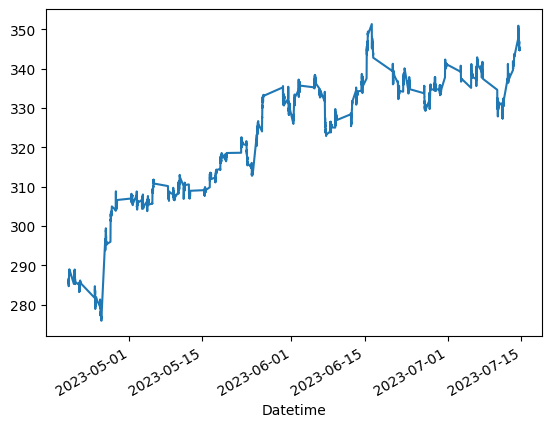

In [6]:
df['Open'].plot()

<Axes: xlabel='Datetime'>

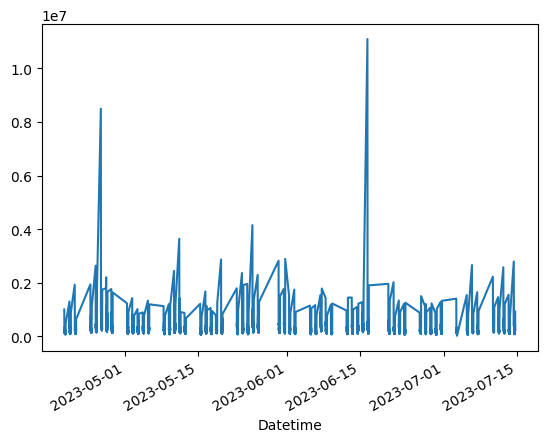

In [7]:
df['Volume'].plot()

Looks good!

We are going to attempt to forecast opening prices, so let's throw away everything else.

In [8]:
df2 = df.copy()
df = df['Open']
df.head()

Datetime
2023-04-19 09:30:00-04:00    285.989990
2023-04-19 09:35:00-04:00    286.619995
2023-04-19 09:40:00-04:00    285.279999
2023-04-19 09:45:00-04:00    285.450012
2023-04-19 09:50:00-04:00    285.899994
Name: Open, dtype: float64

## Data splitting

I've gone with a 85-10-5 training-validate-test split. Again, not sure what best practice with such data should be, but hopefully we'll do some testing later.

In [9]:
n = len(df)

train_df = df[0:int(n*0.85)]
val_df = df[int(n*0.85):int(n*0.95)]
test_df = df[int(n*0.95):]

# See where the tests start
test_df.head()

Datetime
2023-07-12 09:35:00-04:00    337.089996
2023-07-12 09:40:00-04:00    336.670013
2023-07-12 09:45:00-04:00    337.470001
2023-07-12 09:50:00-04:00    338.779999
2023-07-12 09:55:00-04:00    339.304993
Name: Open, dtype: float64

## Normalization

I nearly tore all my hair out on this. There are several available approaches, each with its drawbacks; min-max scaling can't know the minimum or maximum of out-of sample data and that seems particularly ill suited for compounding processes like stock prices. z-score normalization is probably going to work OK, but financial data is famously [heteroskedastic](https://corporatefinanceinstitute.com/resources/data-science/heteroskedasticity/), so you would expect this to fall apart eventually.

I have available Scikit-Learn's `MinMaxScaler, RobustScaler` and `StandardScaler` and `tf.keras.layers.Normalization` and even `tf.keras.utils.normalize`.

I wasn't able to find decisive advice on suitable normalization: the most direct resource I found was the paper [*Impact of Data Normalization on Stock Index Forecasting*](https://www.mirlabs.org/ijcisim/regular_papers_2014/IJCISIM_24.pdf)
by Nayak et al. (and [this](https://arxiv.org/pdf/1812.05519) very similar paper by a different author.)

They essentially suggested a sigmoid normalization $\hat{x} = \frac{1}{1+e^x}.$
Can/should this be done within the model or as part of preprocessing?

I have for now decided to use `StandardScaler`.

I've also not seen any such models use logarithmic returns instead of raw prices, and I do not fully understand why this is the case. Seems to me that's exactly the missing information a machine learning model needs to supply if it's going to be worth anything. Do your log returns predictions beat a random walk?

I think I should normalize each dataset separately, so as not to leak the test data into the training set. It probably wouldn't matter all that much anyway.

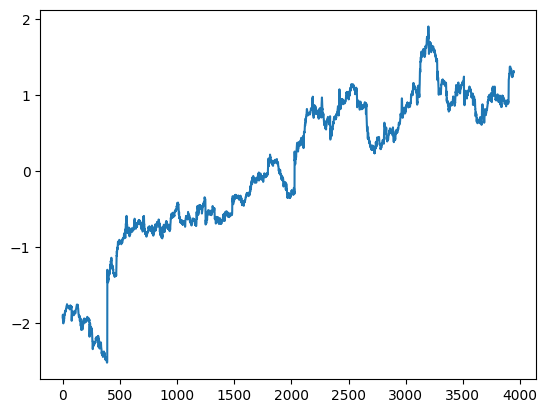

In [10]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

training_opens = train_df.values.reshape(-1, 1) # scaler takes 2D arrays
scaled_training_opens = sc.fit_transform(training_opens)
plt.plot(scaled_training_opens)

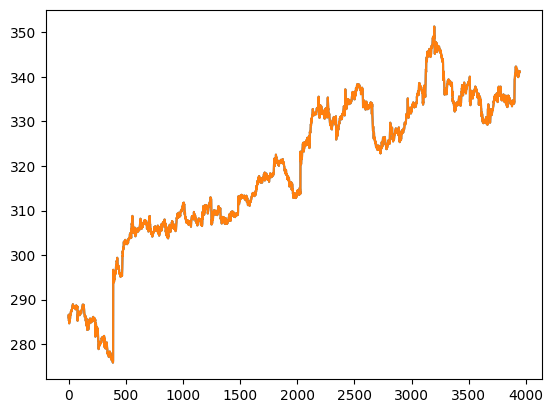

In [11]:
# Just checking;
inv = sc.inverse_transform(scaled_training_opens)
plt.plot(inv)
plt.plot(training_opens)

Phew! Now we scale the validation and test data:

In [12]:
val_opens = val_df.values.reshape(-1,1)
scaled_val_opens = sc.transform(val_opens)

test_opens = test_df.values.reshape(-1,1)
scaled_test_opens = sc.transform(test_opens)
scaled_val_opens.shape

(464, 1)

# Modeling



## Data windowing
There's probably a more elegant way to do this, but I
can't think of it/my Google-fu is not strong enough to find it. I'm positive there's a way without descending into NumPy arrays.

I would use `from keras.preprocessing.sequence import TimeseriesGenerator` but apparently it's deprecated, so
🤷

I've also gone with a sliding window rather than an expanding one. Not sure whether that's better.

In [13]:
def windowing(vec, windowsize=60):
  X = []
  y = []

  for i in range(len(vec) - windowsize):
    x = [v for v in vec[i:i+windowsize]]
    X.append(x)
    label = vec[i+windowsize]
    y.append(label)

  return np.array(X), np.array(y)

In [14]:
X_train,y_train = windowing(scaled_training_opens, 60)
X_val,y_val = windowing(scaled_val_opens, 60)
X_test,y_test = windowing(scaled_test_opens, 60)

## Model training and validation

Let's build a model! I'm still researching what layers the final version should have, and what metrics to use, but here's a preliminary version, just to see what the results should look like.

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError



In [16]:
model1 = Sequential()
model1.add(InputLayer((60,1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Let's save the best performing model:



In [17]:
cp = ModelCheckpoint('model1/',save_best_only=True)
model1.compile(loss='mse',
               optimizer=Adam(learning_rate=0.0001),
               metrics = [RootMeanSquaredError()])

In [18]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100,callbacks=[cp])

Epoch 1/100
122/122 [==============================] - 17s 117ms/step - loss: 0.4907 - root_mean_squared_error: 0.7005 - val_loss: 0.5273 - val_root_mean_squared_error: 0.7262
Epoch 2/100
122/122 [==============================] - 7s 59ms/step - loss: 0.0726 - root_mean_squared_error: 0.2695 - val_loss: 0.0342 - val_root_mean_squared_error: 0.1849
Epoch 3/100
122/122 [==============================] - 7s 57ms/step - loss: 0.0148 - root_mean_squared_error: 0.1215 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1095
Epoch 4/100
122/122 [==============================] - 6s 48ms/step - loss: 0.0093 - root_mean_squared_error: 0.0966 - val_loss: 0.0108 - val_root_mean_squared_error: 0.1040
Epoch 5/100
122/122 [==============================] - 7s 54ms/step - loss: 0.0079 - root_mean_squared_error: 0.0886 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0930
Epoch 6/100
122/122 [==============================] - 6s 45ms/step - loss: 0.0071 - root_mean_squared_error: 0.0845 - val_loss:

Saving the best model:

In [19]:
model1 = tf.keras.models.load_model('model1/')


## Testing

In [20]:
train_predictions = model1.predict(X_train)
train_results = pd.DataFrame(data={'Training Predictions':train_predictions.flatten(), 'Actuals':y_train.flatten()})
train_results

122/122 [==============================] - 1s 7ms/step


,Training Predictions,Actuals
0,-1.797661,-1.791465
1,-1.802750,-1.817262
2,-1.819384,-1.792052
3,-1.815044,-1.779151
4,-1.804951,-1.775633
...,...,...
3880,1.271564,1.301276
3881,1.283715,1.311833
3882,1.296451,1.315352
3883,1.305029,1.301863


In [21]:
val_predictions = model1.predict(X_val)
val_results = pd.DataFrame(data={'Validation Predictions':val_predictions.flatten(), 'Actuals':y_val.flatten()})
val_results

13/13 [==============================] - 0s 7ms/step


,Validation Predictions,Actuals
0,1.067883,1.073748
1,1.067549,1.073748
2,1.067871,1.075509
3,1.069353,1.063193
4,1.064486,1.070230
...,...,...
399,0.728698,0.731283
400,0.731778,0.747702
401,0.743318,0.799307
402,0.776350,0.778197


Now the moment of truth:

In [22]:
test_predictions = model1.predict(X_test)
test_results = pd.DataFrame(data={'Test Predictions':test_predictions.flatten(), 'Actuals':y_test.flatten()})
test_results

6/6 [==============================] - 0s 6ms/step


,Test Predictions,Actuals
0,1.148592,1.134150
1,1.142198,1.128286
2,1.134783,1.105896
3,1.119534,1.106589
4,1.110933,1.117144
...,...,...
168,1.536690,1.542293
169,1.537144,1.527633
170,1.530410,1.516491
171,1.520255,1.513558


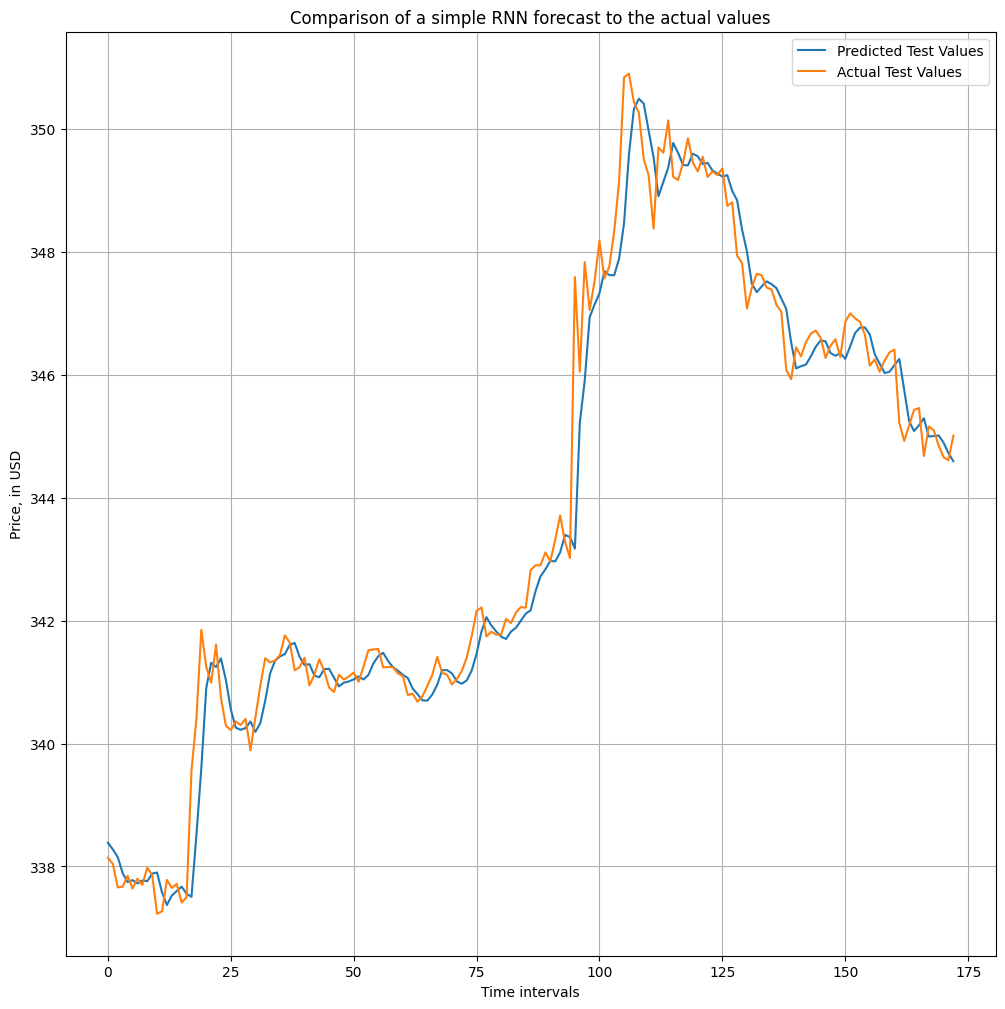

In [32]:
plt.figure(figsize=(12,12))
plt.rc('text', usetex=False)
plt.plot(sc.inverse_transform(test_predictions), label='Predicted Test Values')
plt.plot(sc.inverse_transform(y_test), label='Actual Test Values')
plt.xlabel('Time intervals')
plt.ylabel('Price, in USD')
plt.title('Comparison of a simple RNN forecast to the actual values')
plt.grid()
plt.legend()
plt.show()


Not bad for a first attempt!

# Prediction and uncertainty
When I get some time I will compare then the prediction accuracy among some different models:

  1. Naive Benchmark: Using previous entry as next prediction.  
  2. Quantile Regression Forest.
  3. A basic stacked LSTM. I'm going to add a few layers and dropouts to our model above.
  4. A BNN.
  5. A standard ARIMA.
  6. Prophet.
  

  We will also try to get some decent uncertainty estimates on the predictions.


  A question: Should the EMH imply that the naive benchmark's error rate is a lower bound for all other models? Which error rate(s) would that be?